In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
REGULAR_PATH = 'F:/School/BlockchainCrawler/arbitrum_cache/' + 'receiptsCache_ARBITRUM_NON_ARBITRAGE.json'
ARBITRAGE_PATH = 'F:/School/BlockchainCrawler/arbitrum_cache/' + 'receiptsCache_ARBITRUM_ARBITRAGE.json'

In [3]:
def process_json(path, label):
    with open(path) as file:
        transactions = json.load(file)

        senders, receivers, fees, rounded_fees = [], [], [], []
        for transaction in transactions:
            transaction = transactions[transaction]
            
            sender = transaction['from']
            receiver = transaction['to']
            used_gas = transaction['gasUsed']['hex'] # Seems to equal the transaction fee
            # cumulative_gas = transaction['cumulativeGasUsed']['hex'] # Not sure what this is
            # effective_gas = transaction['effectiveGasPrice']['hex'] # Seems to equal the gas price paid

            # Convert gas from hex to Gwei
            used_gas = convert_gas(used_gas)
            rounded_used_gas = round(used_gas, -3)

            senders.append(sender)
            receivers.append(receiver)
            fees.append(used_gas)
            rounded_fees.append(rounded_used_gas)

    return senders, receivers, fees, rounded_fees

def convert_gas(gas):
    return int(int(gas, 16) / 100)

reg_senders, reg_receivers, reg_fees, reg_rounded_fees = process_json(REGULAR_PATH, 'regular')
arbit_senders, arbit_receivers, arbit_fees, arbit_rounded_fees = process_json(ARBITRAGE_PATH, 'arbitrage')

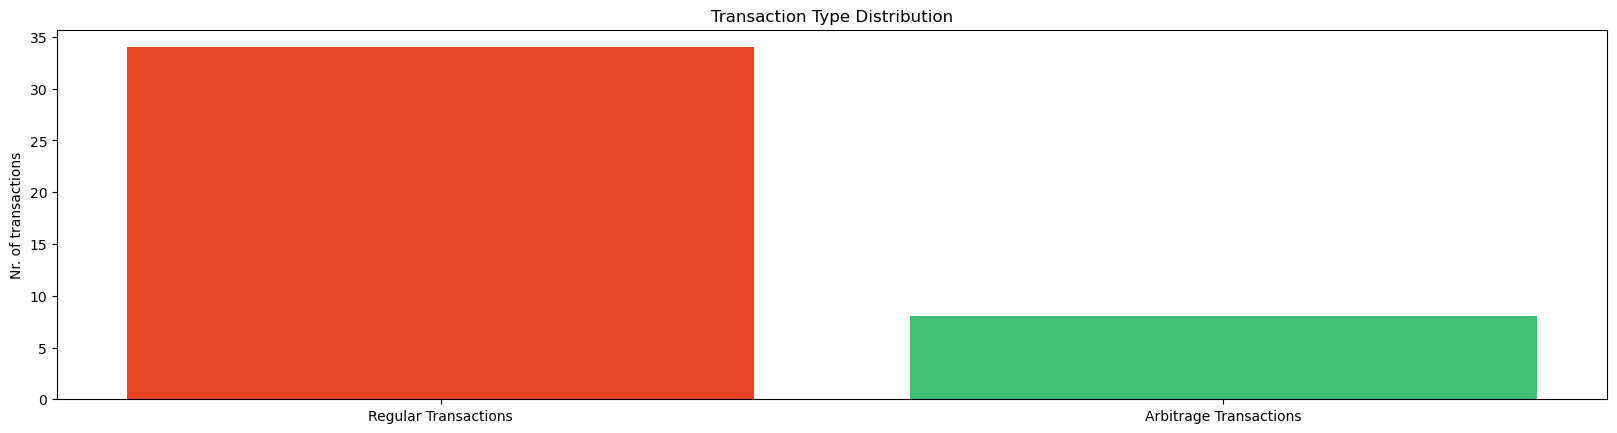

In [4]:
def plot_type_distribution(reg_data, arbit_data):
    figure, axes = plt.subplots()
    figure.set_figwidth(20)

    axes.bar('Regular Transactions', len(reg_data), color='#e54624', label='Regular Transactions')
    axes.bar('Arbitrage Transactions', len(arbit_data), color='#40bf77', label='Arbitrage Transactions')
    axes.set_ylabel('Nr. of transactions')
    axes.set_title('Transaction Type Distribution')

    plt.show()

plot_type_distribution(reg_senders, arbit_senders)

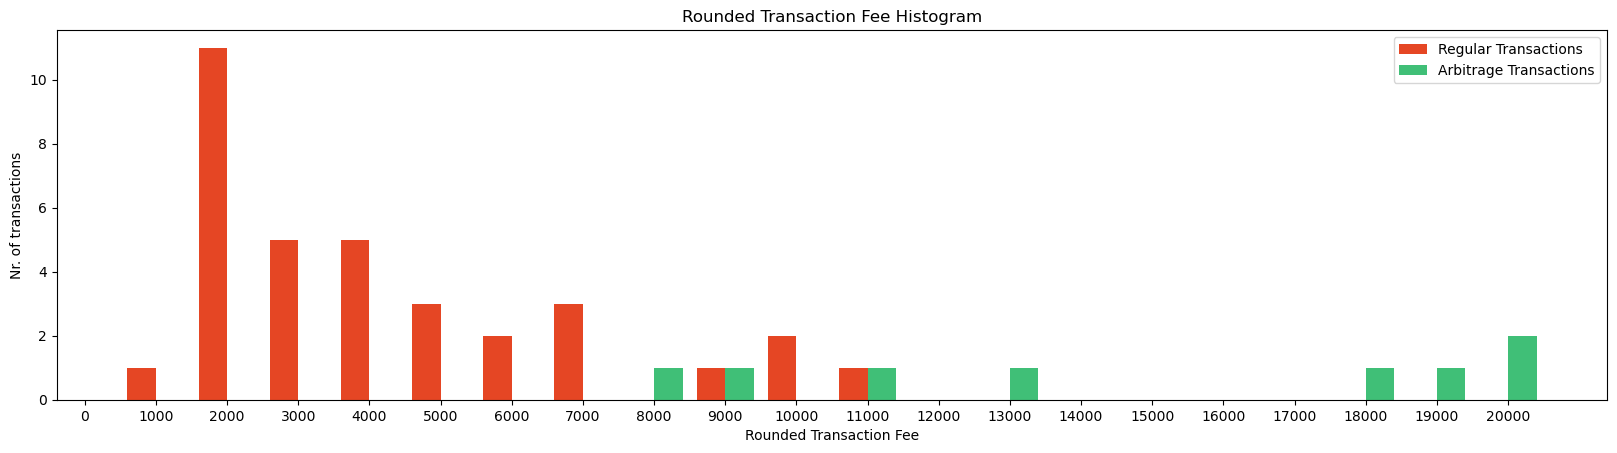

In [5]:
def plot_fees_histogram(reg_values, arbit_values):
    width = 400
    step = 1000
    
    reg_values, reg_counts = get_values_counts(reg_values)
    arbit_values, arbit_counts = get_values_counts(arbit_values)

    figure, axes = plt.subplots()
    figure.set_figwidth(20)

    axes.bar(np.array(reg_values) - (width/2), reg_counts, color='#e54624', width=width, label='Regular Transactions')
    axes.bar(np.array(arbit_values) + (width/2), arbit_counts, color='#40bf77', width=width, label='Arbitrage Transactions')
    axes.set_xlabel('Rounded Transaction Fee')
    axes.set_ylabel('Nr. of transactions')
    axes.set_title('Rounded Transaction Fee Histogram')

    xticks = range(0, max(max(reg_values), max(arbit_values)) + step, step)
    plt.xticks(xticks)
    plt.legend()
    plt.show()

def get_values_counts(values):
    value_counter = Counter(values)
    values = list(value_counter.keys())
    counts = list(value_counter.values())

    return values, counts

plot_fees_histogram(reg_rounded_fees, arbit_rounded_fees)

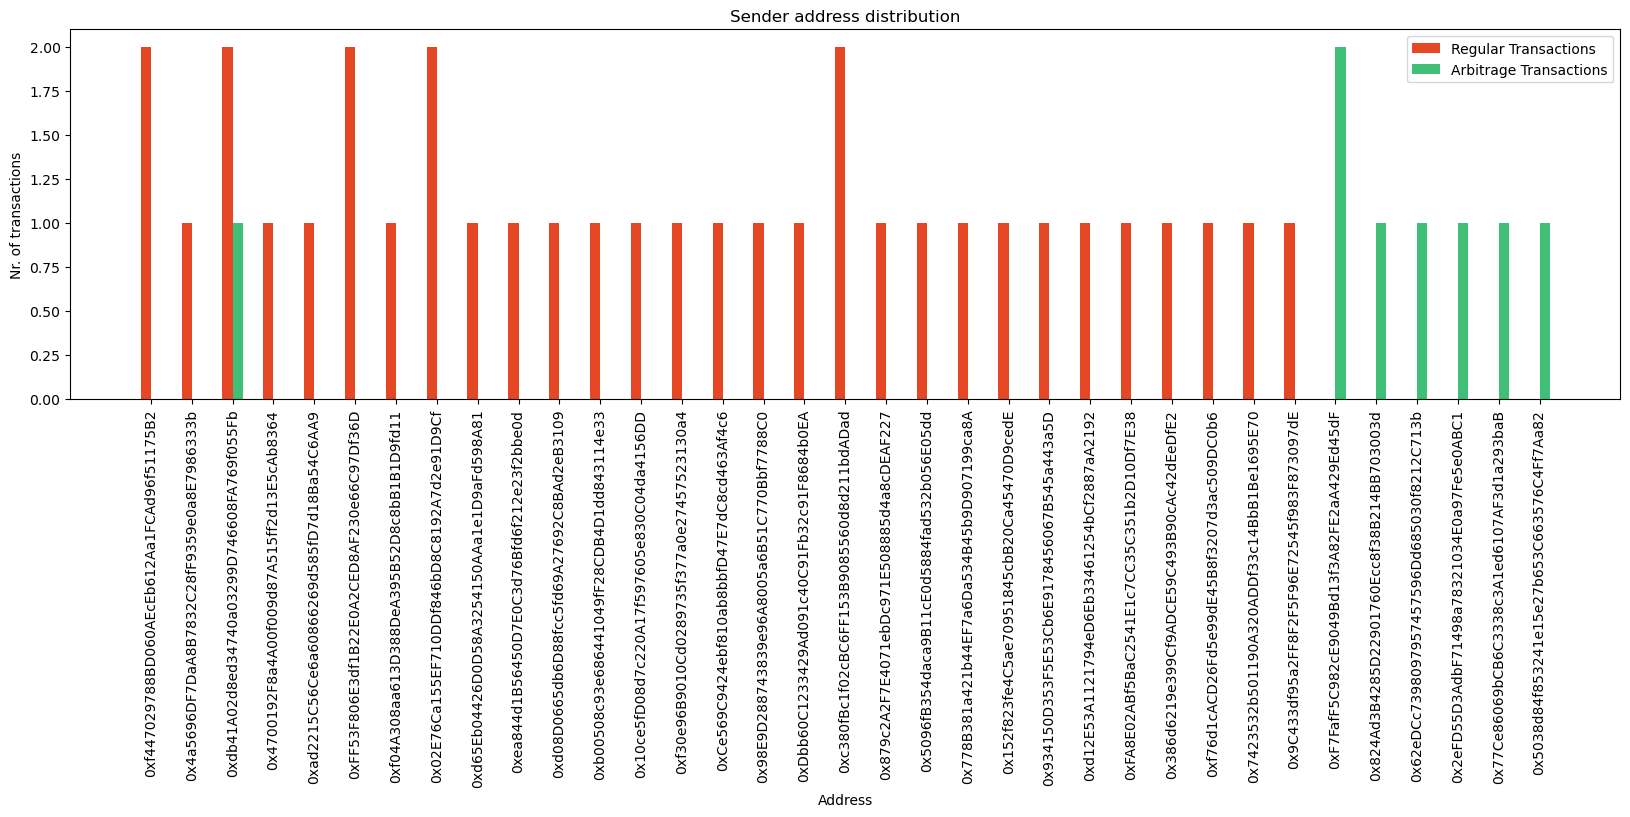

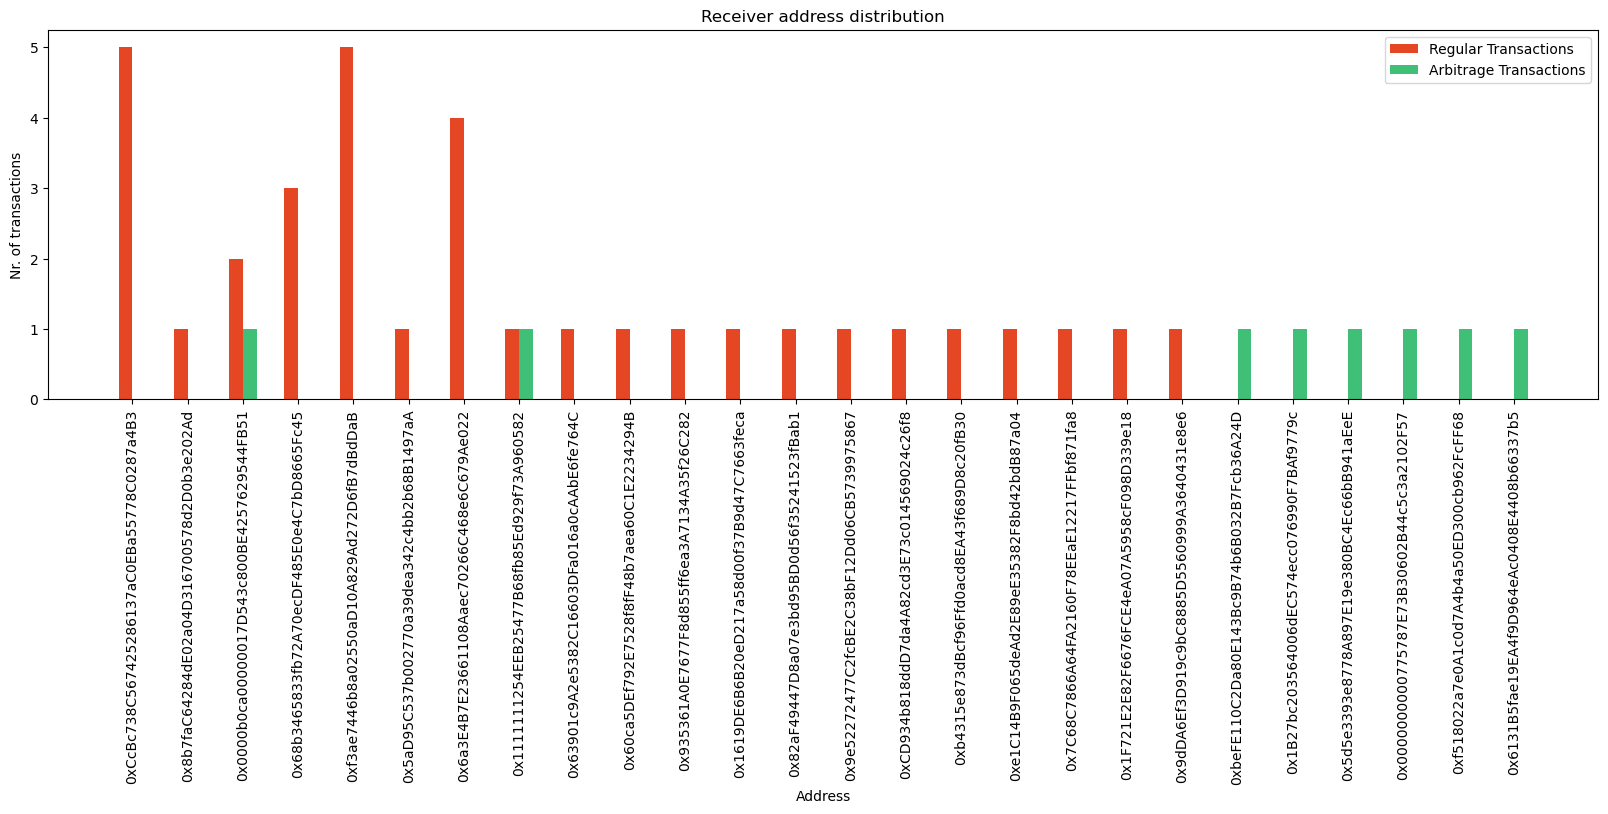

In [6]:
def plot_address_counts(reg_addresses, arbit_addresses, title):
    reg_values, reg_counts = get_values_counts(reg_addresses)
    arbit_values, arbit_counts = get_values_counts(arbit_addresses)

    # Combine the values and counts while removing duplicates and adding 0s where neccessary
    values, reg_counts, arbit_counts = combine_values_and_counts(reg_counts, reg_values, arbit_counts, arbit_values)

    figure, axes = plt.subplots()
    figure.set_figwidth(20)

    width = 0.25
    indexes = np.arange(len(values))
    axes.bar(indexes - (width / 2), reg_counts, color='#e54624', width=width, label='Regular Transactions')
    axes.bar(indexes + (width / 2), arbit_counts, color='#40bf77', width=width, label='Arbitrage Transactions')
    
    axes.set_xlabel('Address')
    axes.set_ylabel('Nr. of transactions')
    axes.set_title(title)

    axes.set_xticks(indexes)
    axes.set_xticklabels(values)
    plt.xticks(rotation=90)

    plt.legend()
    plt.show()

def combine_values_and_counts(counts1, values1, counts2, values2):
    values = []
    [values.append(value) for value in values1 if value not in values]
    [values.append(value) for value in values2 if value not in values]
    
    new_counts1, new_counts2 = [], []
    for value in values:
        if value in values1:
            value1_count = counts1[values1.index(value)]
        else:
            value1_count = 0

        if value in values2:
            value2_count = counts2[values2.index(value)]
        else:
            value2_count = 0

        new_counts1.append(value1_count)
        new_counts2.append(value2_count)

    return values, new_counts1, new_counts2

plot_address_counts(reg_senders, arbit_senders, 'Sender address distribution')
plot_address_counts(reg_receivers, arbit_receivers, 'Receiver address distribution')